# Finetuned Multi-Label Model
This notebook trains a multilabel multilayer perceptron model to classify species observed in Mt Kenya. We use embeddings obtained from the  Google's Perch Model ([Bird Vocalization Classifier](https://www.kaggle.com/models/google/bird-vocalization-classifier)).

The embeddings for all files are obtained by running the code below. Embeddings for recordings with single species are part of the [Ndege Zetu dataset](https://datadryad.org/dataset/doi:10.5061/dryad.d51c5b0c7).

* `python compute_file_embeddings.py -i ../audio/ -e ../embeddings/`

In [1]:
import os
import json
import random
import numpy as np
import pandas as pd


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


from keras.utils import to_categorical, set_random_seed

2025-02-27 06:58:55.900241: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-27 06:58:55.900311: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-27 06:58:55.902486: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 06:58:55.931924: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-27 06:58:57.833867: W tensorflow/compiler/tf2

In [2]:
def species_from_df(df):
    '''
    This function extracts species from the audio annotation files
    '''
    sps = []
    for i in range(len(df)):
        if not pd.isna(df.iloc[i]['Foreground Species']):
            sps += df.iloc[i]['Foreground Species'].split(';')
        if not pd.isna(df.iloc[i]['Background Species']):
            sps += df.iloc[i]['Background Species'].split(';')
    return list(set(sps))

def get_opt_thresh(y_train, y_pred):
    '''
    Get the optimal probability threshold for sigmoid output
    '''
    num_points = 1000
    thresh = np.linspace(.01,1, num_points)
    acc = np.zeros(num_points)
    
    for i, th in enumerate(thresh):
        acc[i] = accuracy_score(y_train, (y_pred > th).astype(int))
    return thresh[np.argmax(acc)]

def create_model(hidden_layers, input_size, output_size):
    '''
    Create an MLP
    '''
    model = Sequential()
    if len(hidden_layers):
        model.add(Dense(hidden_layers[0], input_dim=input_size, kernel_initializer='he_uniform', activation='relu'))
    for indx, hl in hidden_layers[1:]:
        model.add(Dense(hidden_layers[indx], input_dim=hidden_layers[indx - 1], kernel_initializer='he_uniform', activation='relu'))

    model.add(Dense(output_size, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
    

In [3]:
annotations_dir = '../annotations/'

In [4]:
annotation_files = os.listdir(annotations_dir)
    
# audio 
aru_dfs = []
for filename in annotation_files:
    if 'aru' in filename  and filename.endswith('csv'):
    
        df = pd.read_csv(os.path.join(annotations_dir, filename))
        aru_dfs.append(df)
    
annotations = pd.concat(aru_dfs)
aru_cns = species_from_df(annotations)
aru_cns.sort()

# scientific names
df_sp = pd.read_csv('../annotations/Kenya-Species-List.csv')
aru_sns = [df_sp[df_sp['Common Name']==cn].iloc[0]['Scientific Name'] for cn in aru_cns]

In [5]:
# get number of files with species
num_files = 0
for indx, filename in enumerate(list(annotations['Filename'])):

    recording_cn = []
    if not pd.isna(annotations.iloc[indx]['Foreground Species']):
        recording_cn += annotations.iloc[indx]['Foreground Species'].split(';')
    if not pd.isna(annotations.iloc[indx]['Background Species']):
        recording_cn += annotations.iloc[indx]['Background Species'].split(';')
    
    if len(recording_cn):
        num_files += 1

recording_species = np.zeros((num_files, len(aru_sns)))

In [6]:
curr_file = 0    
recording_filename = []
for indx, filename in enumerate(list(annotations['Filename'])):

    recording_cn = []
    if not pd.isna(annotations.iloc[indx]['Foreground Species']):
        recording_cn += annotations.iloc[indx]['Foreground Species'].split(';')
    if not pd.isna(annotations.iloc[indx]['Background Species']):
        recording_cn += annotations.iloc[indx]['Background Species'].split(';')

    recording_sn = [df_sp[df_sp['Common Name']==cn].iloc[0]['Scientific Name'] for cn in recording_cn]

    if len(recording_cn):
        recording_filename.append(filename)
        
        for sp in recording_sn:
            recording_species[curr_file, aru_sns.index(sp)] = 1
            
        curr_file += 1
            

## Number of Species per Recording - Figure 8

The recordings have multiple species. We plot the distribution of number of species per recording.

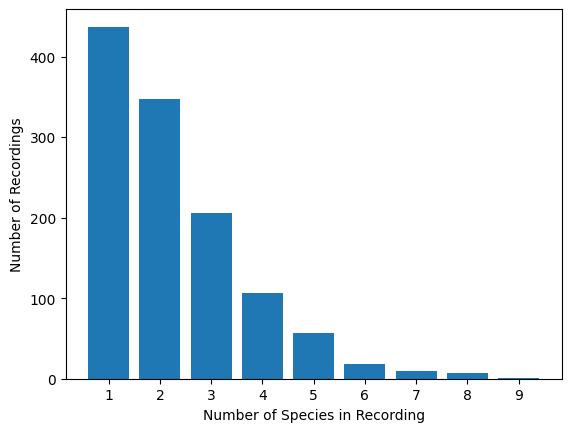

In [7]:
num_dist = Counter(np.sum(recording_species, 1))
plt.bar(num_dist.keys(), num_dist.values())
plt.xticks(range(1,10));

plt.xlabel('Number of Species in Recording')
plt.ylabel('Number of Recordings')

plt.savefig('recording-species.jpg', dpi=300)

In [8]:
num_sp_rec = np.sum(recording_species, 0)

In [9]:
filtered_species = []
recording_threshold = 20

for i, status in enumerate(num_sp_rec >= recording_threshold):
    if status:
        filtered_species.append(aru_cns[i])
        

In [10]:
for sp in filtered_species:
    print(sp, num_sp_rec[aru_cns.index(sp)])

Black-backed Puffback 33.0
Brown Woodland Warbler 519.0
Cape Robin Chat 22.0
Chestnut-throated Apalis 132.0
Chin-spot Batis 38.0
Cinnamon Bracken Warbler 82.0
Cinnamon-chested Bee-eater 28.0
Collared Sunbird 41.0
Common Bulbul 150.0
Grey Apalis 28.0
Grey-backed Camaroptera 179.0
Hartlaub's Turaco 113.0
Montane White-eye 76.0
Mountain Yellow Warbler 77.0
Olive Thrush 31.0
Red-fronted Parrot 100.0
Rüppell's Robin Chat 29.0
Tambourine Dove 50.0
Tropical Boubou 113.0
Variable Sunbird 38.0
White-starred Robin 70.0
Yellow-breasted Apalis 22.0
Yellow-rumped Tinkerbird 124.0
Yellow-whiskered Greenbul 221.0


In [11]:
y = recording_species[:,num_sp_rec >= recording_threshold]

In [12]:
len(recording_filename)

1188

## Train Model
We obtain embeddings and use the mean embedding per file as the feature.

In [13]:
embeddings_dir = '../embeddings/'
mean_embeddings = np.array([])
for filename in recording_filename:
    
    npzfile = np.load(os.path.join(embeddings_dir, filename.replace('mp3','npz')))
    file_embeddings = npzfile['embeddings']

    if mean_embeddings.size:
        mean_embeddings = np.vstack((mean_embeddings, np.mean(file_embeddings, 0)))
    else:
        mean_embeddings = np.mean(file_embeddings, 0)

In [14]:
mean_embeddings.shape

(1188, 1280)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(mean_embeddings, y, test_size=0.3, random_state=12)    

In [16]:
input_size = X_train.shape[1]
hidden_layer_size = 200
output_size = y.shape[1]

In [17]:
np.random.seed(123)
set_random_seed(123)

callback = EarlyStopping(monitor='val_loss', patience=10)
model = create_model(hidden_layers=(200,), input_size=input_size, output_size=output_size)
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), verbose=0, epochs=100, callbacks=[callback])

y_pred = model.predict(X_test, verbose=0)


macro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_pred,
    multi_class="ovr",
    average="macro",
)

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

2025-02-27 06:59:04.896077: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-02-27 06:59:04.973465: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Macro-averaged One-vs-Rest ROC AUC score:
0.91


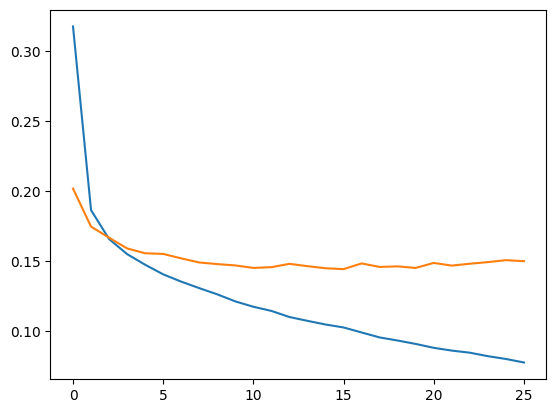

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
y_pred = model.predict(X_train, verbose=0)
opt_thresh = get_opt_thresh(y_train, y_pred)

y_pred = model.predict(X_test, verbose=0)
accuracy_score(y_test, (y_pred > opt_thresh).astype(int))

0.27170868347338933

In [20]:
y_pred_thresh = (y_pred > opt_thresh).astype(int)

In [21]:
model.save("multi-species.keras")

In [22]:
pre = []
recall = []
f1 = []
for indx, sp in enumerate(filtered_species):
    pre.append(precision_score(y_test[:,indx], y_pred_thresh[:,indx]))
    recall.append(recall_score(y_test[:,indx], y_pred_thresh[:,indx]))
    f1.append(f1_score(y_test[:,indx], y_pred_thresh[:,indx]))

res_df = pd.DataFrame(zip(filtered_species,pre,recall,f1), columns=['Common Name', 'Precision', 'Recall', 'F1-Score'])

In [23]:
res_df.sort_values(by=['F1-Score'], ascending=False).round(2)

,Common Name,Precision,Recall,F1-Score
1,Brown Woodland Warbler,0.86,0.86,0.86
23,Yellow-whiskered Greenbul,0.66,0.73,0.69
8,Common Bulbul,0.56,0.85,0.67
10,Grey-backed Camaroptera,0.68,0.64,0.66
11,Hartlaub's Turaco,0.75,0.53,0.62
22,Yellow-rumped Tinkerbird,0.69,0.50,0.58
17,Tambourine Dove,0.46,0.67,0.55
4,Chin-spot Batis,0.88,0.39,0.54
15,Red-fronted Parrot,0.44,0.67,0.53
13,Mountain Yellow Warbler,0.75,0.41,0.53


In [24]:
res_df.to_csv('multi-species-mlp.csv')

In [25]:
num_trial = 100
trial = 0

np.random.seed(123)
set_random_seed(123)

mlp_auc = []
mlp_acc = []


while trial < num_trial:
    X_train, X_test, y_train, y_test = train_test_split(mean_embeddings, y, test_size=0.3)
    
    model = create_model(hidden_layers=(200,), input_size=input_size, output_size=output_size)
    

    if sum(np.sum(y_train, 0) > 0)  == y.shape[1]  and sum(np.sum(y_test, 0) > 0)  == y.shape[1]:
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), verbose=0, epochs=100, callbacks=[callback])

        y_pred = model.predict(X_train, verbose=0)
        opt_thresh = get_opt_thresh(y_train, y_pred)

        y_pred = model.predict(X_test, verbose=0)
        accuracy = accuracy_score(y_test, (y_pred > opt_thresh).astype(int))
        
        macro_roc_auc_ovr = roc_auc_score(
                                y_test,
                                y_pred,
                                multi_class="ovr",
                                average="macro",
                            )
                            

        mlp_auc.append(macro_roc_auc_ovr)
        mlp_acc.append(accuracy)

       
        trial += 1

print('Mean AUC: {}, Mean Accuracy {}'.format(np.mean(mlp_auc), np.mean(mlp_acc)))

Mean AUC: 0.904286543826602, Mean Accuracy 0.30577030812324923
